# Library import

In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import LinearSegmentedColormap

import scipy
from scipy import signal
from scipy import stats
from scipy import ndimage

import numpy as np
from numpy import ma

import pandas as pd

from skimage import io
from skimage import filters
from skimage import measure
from skimage.measure import regionprops, label
from skimage import morphology
from skimage import segmentation
from skimage.segmentation import watershed
from skimage.segmentation import mark_boundaries
from skimage.feature import peak_local_max

import sympy as sp

# Image

In [14]:
# Import image file (if you have .tiff):
img_raw = io.imread(r'C:\Users\USER\image_analysis\data\example_image.tif')

#Check shape of data
print(img_raw.shape)

(2, 31, 1024, 1024)


In [29]:
name = "example_image"
date = "170125"
op_date = "co"
group = "co"
paw = "co"
spot = "ps"
pixel_size = 0.317 

## For multichannel

In [16]:
ch0_img_raw = img_raw[0]
ch1_img_raw = img_raw[1]

print(ch0_img_raw.shape) 
print(ch1_img_raw.shape) 

(31, 1024, 1024)
(31, 1024, 1024)


### Max image projection

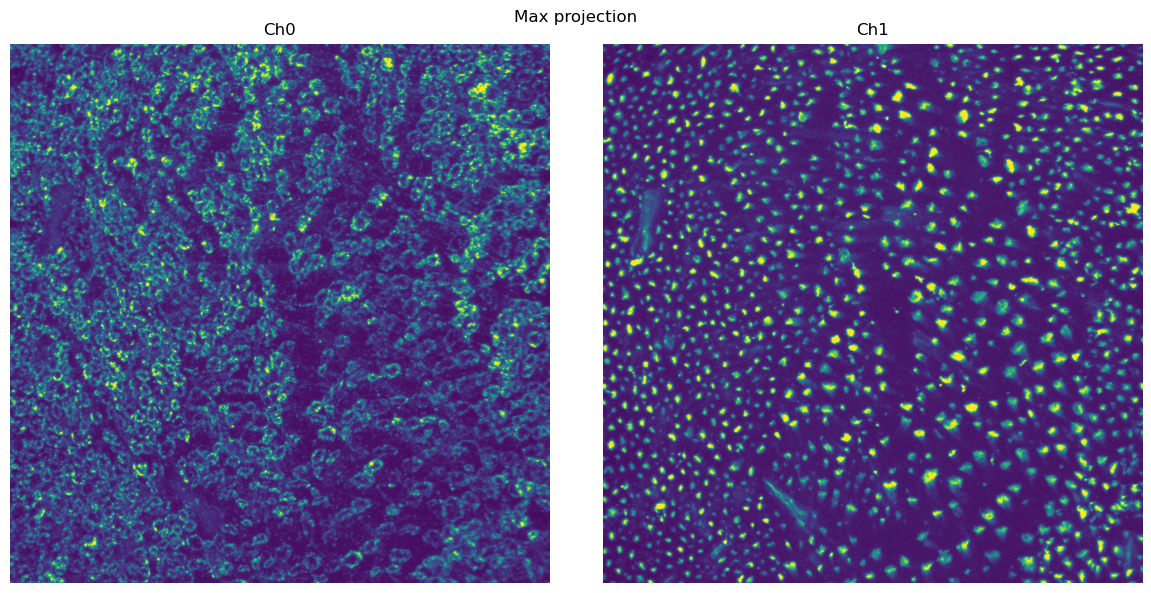

In [49]:
# Max projection
ch0_img_raw_max = np.max(ch0_img_raw, axis=0)
ch1_img_raw_max = np.max(ch1_img_raw, axis=0)

plt.figure(figsize=(12,6))

ax0 = plt.subplot(121) 
ax0.imshow(ch0_img_raw_max)
ax0.set_title('Ch0')
ax0.axis('off')

ax1 = plt.subplot(122) 
ax1.imshow(ch1_img_raw_max)
ax1.set_title('Ch1')
ax1.axis('off')

plt.suptitle('Max projection')

plt.tight_layout()

plt.savefig(r'C:\Users\USER\image_analysis\results\results_axon\segmented_data_axon\example_image\01_max_projection.png', format='png', dpi=300)

plt.show()

## Preprocessing

### Intensities correction

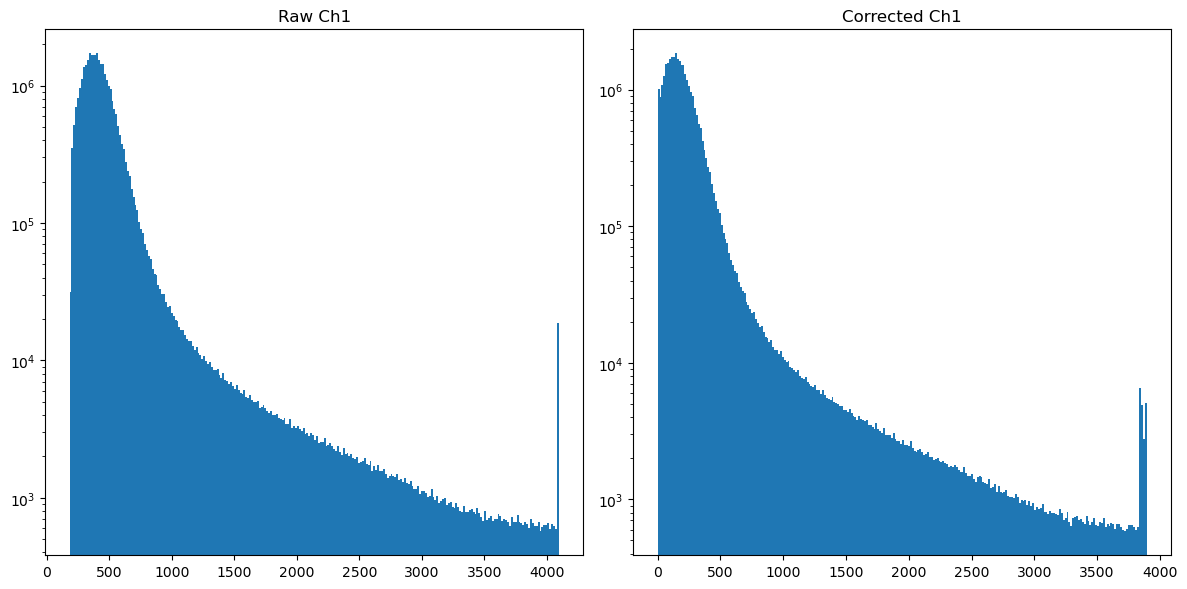

In [50]:
# Correction
bc_p = lambda x:np.array([f - np.percentile(f, 1) for f in x]).clip(min=0).astype(dtype=x.dtype)

ch0_img_corr = bc_p(ch0_img_raw)
ch1_img_corr = bc_p(ch1_img_raw)

#Plot
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(12,6))

ax0.hist(ch1_img_raw.ravel(), bins=256)
ax0.set_yscale('log')
ax0.set_title('Raw Ch1')

ax1.hist(ch1_img_corr.ravel(), bins=256)
ax1.set_yscale('log')
ax1.set_title('Corrected Ch1')

plt.tight_layout()

plt.savefig(r'C:\Users\USER\image_analysis\results\results_axon\segmented_data_axon\example_image\02_correction_plot.png', format='png', dpi=300)

plt.show()

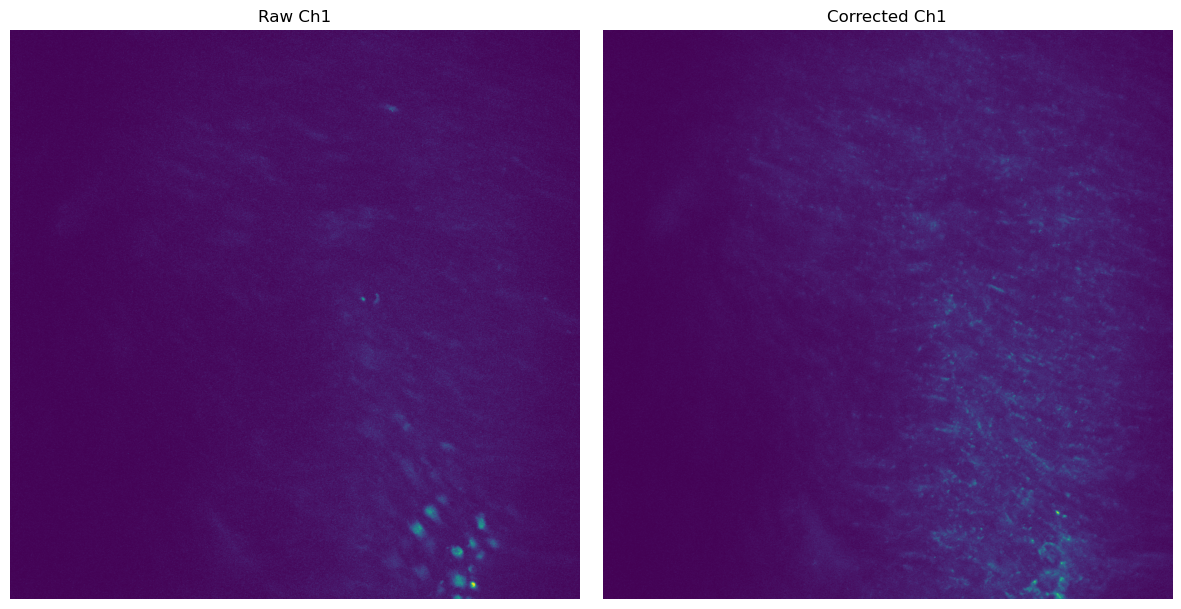

In [19]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(12,6))

ax0.imshow(ch1_img_raw[0])
#ax0.imshow(ch1_img_raw[1])
ax0.set_title('Raw Ch1')
ax0.axis('off')

ax1.imshow(ch0_img_corr[0])
ax1.set_title('Corrected Ch1')
ax1.axis('off')

plt.tight_layout()
plt.show()

### Median Filter

In [13]:
# Choosing right corrected channel fur further work

#channel_corr = ch0_img_corr # myelin channel
channel_corr = ch1_img_corr # axon channel

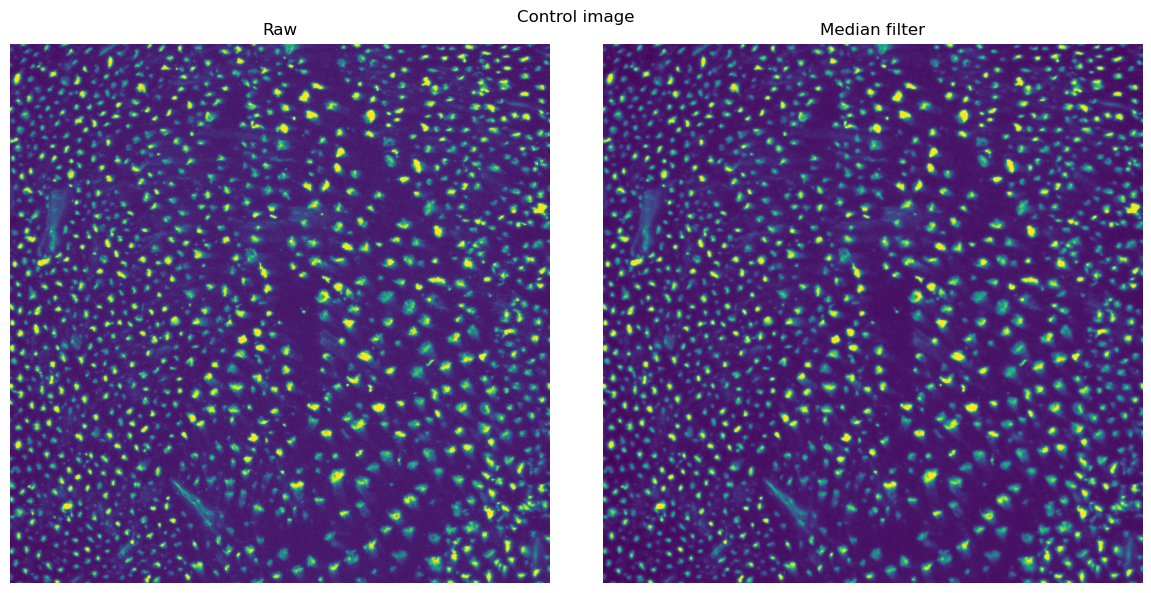

In [51]:
# Max projecon of chosen corrected channel for further detection
nfh_det_img_raw = np.max(channel_corr, axis=0)

# Filtering 
morphology_disk_median = 2 # try out different number, to look out how the filtered image changes
nfh_det_img = filters.median(nfh_det_img_raw,
                              footprint=morphology.disk(morphology_disk_median)) # in future work you can change filters.median to other filters

# Plot
plt.figure(figsize=(12,6))

ax0 = plt.subplot(121)  # raw image
ax0.imshow(nfh_det_img_raw)
ax0.set_title('Raw')
ax0.axis('off')

ax1 = plt.subplot(122)  # image aftre applying morphology.disk, or Gauss filter
ax1.imshow(nfh_det_img)
ax1.set_title('Median filter')
ax1.axis('off')

plt.suptitle('Control image')

plt.tight_layout()

plt.savefig(r'C:\Users\USER\image_analysis\results\results_axon\segmented_data_axon\example_image\03_median_filter.png', format='png', dpi=300)

plt.show()

### Threshold Otsu

[1037 2353]


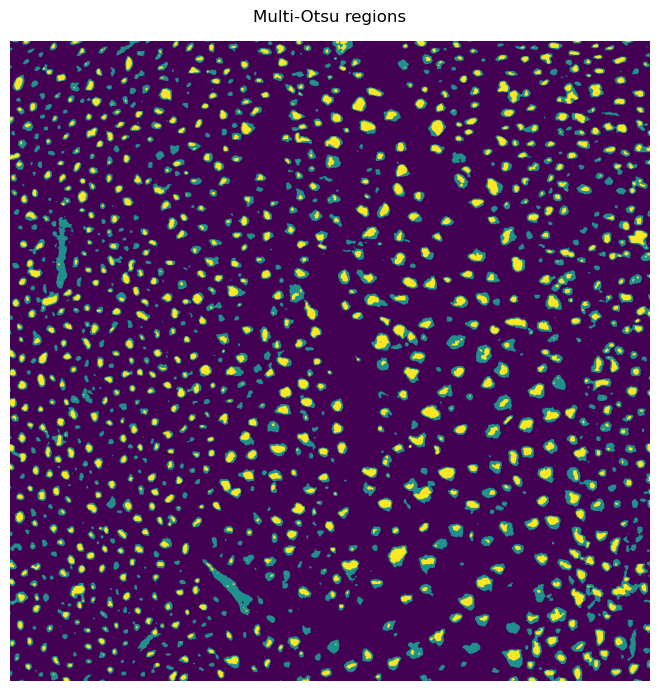

In [56]:
# Detecting Otsu Thresholds
thresholds = filters.threshold_multiotsu(nfh_det_img)
print(thresholds)

# Differentiation of regions by thresholds
regions_img = np.digitize(nfh_det_img, bins=thresholds)


# Plot
plt.figure(figsize=(10,7))
plt.imshow(regions_img)  # Multi-Otsu regions
plt.suptitle('Multi-Otsu regions')
plt.axis('off')

plt.tight_layout()

plt.savefig(r'C:\Users\USER\image_analysis\results\results_axon\segmented_data_axon\example_image\04_multi_otsu.png', format='png', dpi=300)

plt.show()

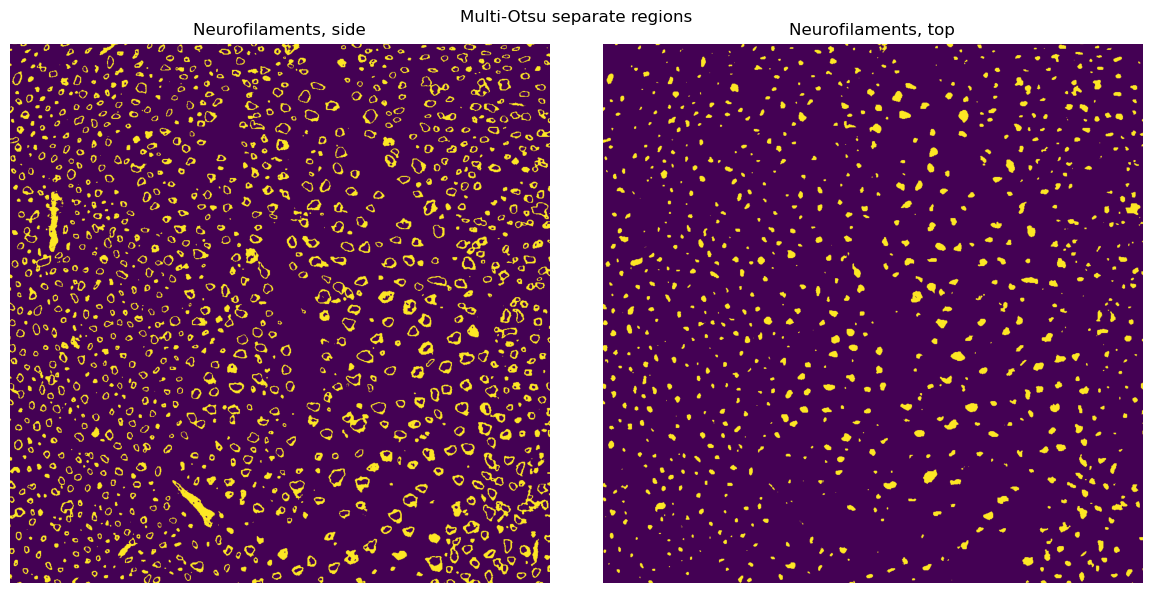

In [57]:
# Boolean masks of individual regions
length_mask_raw = regions_img == 1
top_mask_raw = regions_img == 2

# Plot
plt.figure(figsize=(12,6))

ax0 = plt.subplot(121)  # Side regions - we aren`t interested in them
ax0.imshow(length_mask_raw)
ax0.set_title('Neurofilaments, side')
ax0.axis('off')

ax1 = plt.subplot(122)  # Top regions - that`s what we need
ax1.imshow(top_mask_raw)
ax1.set_title('Neurofilaments, top')
ax1.axis('off')

plt.suptitle('Multi-Otsu separate regions')

plt.tight_layout()

plt.savefig(r'C:\Users\USER\image_analysis\results\results_axon\segmented_data_axon\example_image\05_multi_otsu_separated_regions.png', format='png', dpi=300)

plt.show()

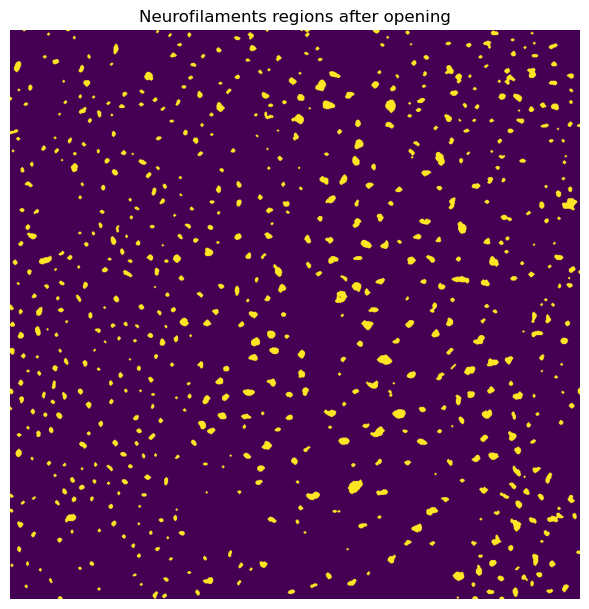

In [58]:
morphology_disk_opening = 2
nfh_mask = morphology.opening(top_mask_raw, footprint=morphology.disk(morphology_disk_opening))

# Plot
plt.figure(figsize=(12,6))

ax1 = plt.subplot(122)
ax1.imshow(nfh_mask)
ax1.set_title('Neurofilaments regions after opening')
ax1.axis('off')

plt.tight_layout()

plt.savefig(r'C:\Users\USER\image_analysis\results\results_axon\segmented_data_axon\example_image\06_opening_filter.png', format='png', dpi=300)

plt.show()

In [26]:
# Watershed segmentation
distance = ndimage.distance_transform_edt(nfh_mask.astype(bool))
local_maxi = peak_local_max(distance, footprint=np.ones((3, 3)), labels=nfh_mask)
peaks_mask = np.zeros_like(distance, dtype=bool)
peaks_mask[tuple(local_maxi.T)] = True
markers = morphology.label(peaks_mask)
labels_ws = watershed(-distance, markers, mask=nfh_mask)
ans = mark_boundaries(nfh_mask, labels_ws, color=(1, 1, 0), outline_color=(1,0,1), mode='inner', background_label=0)

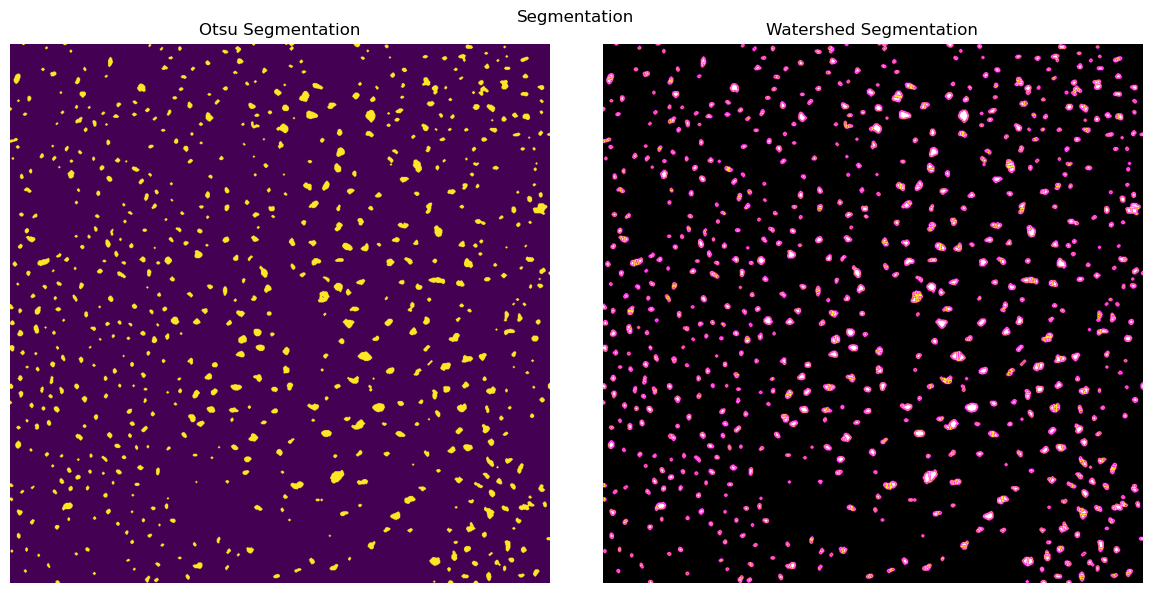

In [59]:
plt.figure(figsize=(12,6))

ax0 = plt.subplot(121)
ax0.imshow(nfh_mask )
ax0.set_title('Otsu Segmentation')
ax0.axis('off')

ax1 = plt.subplot(122)
ax1.imshow(ans)
ax1.set_title('Watershed Segmentation')
ax1.axis('off')

plt.suptitle('Segmentation')

plt.tight_layout()

plt.savefig(r'C:\Users\USER\image_analysis\results\results_axon\segmented_data_axon\example_image\07_watershed.png', format='png', dpi=300)

plt.show()

In [ ]:
# Making some calculations based on watershed segmentation
nfh_quantity = measure.regionprops(labels_ws)

# Making list
region_data = []

# Making formula for choosing parameters? that interests us
for region in nfh_quantity:
    region_data.append({
        "label": region.label,
        "area": region.area*pixel_size, 
        "minor_length": region.axis_minor_length*pixel_size, # Our assomption is that minor length = diameter of axons
        "major_length": region.axis_major_length*pixel_size
    })

# Making dataframe with results
region_data_df = pd.DataFrame(region_data)
region_data_df

label    area  minor_length  major_length
0         1   7.291      1.302333      2.418188
1         2   9.510      1.300413      3.100023
2         3   7.608      1.592029      1.971186
3         4   5.072      1.227736      1.677406
4         5  15.533      1.838065      3.722127
...     ...     ...           ...           ...
999    1000  15.850      2.166846      2.983162
1000   1001   4.121      1.315866      1.315866
1001   1002  10.778      1.643919      2.720673
1002   1003  13.314      1.671883      3.347509
1003   1004   9.827      1.459964      2.862641

[1004 rows x 4 columns]

In [35]:
# Making final dataset with all data for our picture

nfh_quantity_df = measure.regionprops_table(labels_ws, intensity_image=nfh_det_img, properties=("label", "intensity_mean", "area", "axis_major_length", "axis_minor_length"))
nfh_quantity_df['major_length_um'] = nfh_quantity_df['axis_major_length'] * pixel_size
nfh_quantity_df['minor_length_um'] = nfh_quantity_df['axis_minor_length'] * pixel_size

nfh_quantity_df['axis_ratio'] = np.divide(nfh_quantity_df['axis_minor_length'], nfh_quantity_df['axis_major_length'])

nfh_quantity_df['name'] = name
nfh_quantity_df['date'] = date
nfh_quantity_df['op_date'] = op_date
nfh_quantity_df['group'] = group
nfh_quantity_df['paw'] = paw 
nfh_quantity_df['spot'] = spot

nfh_quantity_df = pd.DataFrame(nfh_quantity_df)

nfh_quantity_df

label  intensity_mean  area  axis_major_length  axis_minor_length  \
0         1     2984.913043  23.0           7.628352           4.108307   
1         2     3107.533333  30.0           9.779252           4.102249   
2         3     3088.500000  24.0           6.218253           5.022173   
3         4     2612.937500  16.0           5.291503           3.872983   
4         5     2541.795918  49.0          11.741726           5.798312   
...     ...             ...   ...                ...                ...   
999    1000     2666.460000  50.0           9.410605           6.835475   
1000   1001     2516.230769  13.0           4.150996           4.150996   
1001   1002     3426.529412  34.0           8.582566           5.185865   
1002   1003     3368.309524  42.0          10.559966           5.274080   
1003   1004     3289.774194  31.0           9.030415           4.605566   

      major_length_um  minor_length_um  axis_ratio           name    date  \
0            2.418188         1.302333    0.538558  example_image  170125   
1            3.100023         1.300413    0.419485  example_image  170125   
2            1.971186         1.592029    0.807650  example_image  170125   
3            1.677406         1.227736    0.731925  example_image  170125   
4            3.722127         1.838065    0.493821  example_image  170125   
...               ...              ...         ...            ...     ...   
999          2.983162         2.166846    0.726359  example_image  170125   
1000         1.315866         1.315866    1.000000  example_image  170125   
1001         2.720673         1.643919    0.604233  example_image  170125   
1002         3.347509         1.671883    0.499441  example_image  170125   
1003         2.862641         1.459964    0.510006  example_image  170125   

     op_date group paw spot  
0         co    co  co   ps  
1         co    co  co   ps  
2         co    co  co   ps  
3         co    co  co   ps  
4         co    co  co   ps  
...      ...   ...  ..  ...  
999       co    co  co   ps  
1000      co    co  co   ps  
1001      co    co  co   ps  
1002      co    co  co   ps  
1003      co    co  co   ps  

[1004 rows x 14 columns]

In [36]:
# Naking formula for descriptional statistics for our image
def slice_metrics(region_data_df):
    print(f'Number = {np.max(region_data_df["label"])}')
    
    print(f'Minimal minor length = {np.min(region_data_df["minor_length"]):.2f} um')
    print(f'Maximal minor length = {np.max(region_data_df["minor_length"]):.2f} um')
    print(f'Average minor length = {np.mean(region_data_df["minor_length"]):.2f} um')
    print(f'Median minor length = {np.median(region_data_df["minor_length"]):.2f} um')

    print(f'Minimal major length = {np.min(region_data_df["major_length"]):.2f} um')
    print(f'Maximal major length = {np.max(region_data_df["major_length"]):.2f} um')
    print(f'Average major length = {np.mean(region_data_df["major_length"]):.2f} um')
    print(f'Median major length = {np.median(region_data_df["major_length"]):.2f} um')
 
    print(f'Axis ratio = {np.divide(np.mean(region_data_df["major_length"]), np.mean(region_data_df["minor_length"])):.2f}')

In [38]:
slice_metrics(region_data_df)

Number = 1004
Minimal minor length = 0.73 um
Maximal minor length = 5.75 um
Average minor length = 2.13 um
Median minor length = 1.99 um
Minimal major length = 1.27 um
Maximal major length = 7.45 um
Average major length = 2.96 um
Median major length = 2.80 um
Axis ratio = 1.39


In [41]:
# Making dataset with summarized data about our picture

nfh_count = []
nfh_count.append({
    "name": name,
    "date": date,
    "op_date": op_date,
    "group": group,
    "paw": paw,
    "spot": spot,

    "num": np.max(region.label),

    "r2": (stats.linregress(nfh_quantity_df['major_length_um'], nfh_quantity_df['minor_length_um'])).rvalue,
    "slope": (stats.linregress(nfh_quantity_df['major_length_um'], nfh_quantity_df['minor_length_um'])).slope,
    
    "min_minor_l": np.min(df["minor_length"]),
    "max_minor_l": np.max(df["minor_length"]),
    "mean_minor_l": np.mean(df["minor_length"]),
    "median_minor_l": np.median(df["minor_length"]),

    "min_major_l": np.min(df["major_length"]),
    "max_major_l": np.max(df["major_length"]),
    "mean_major_l": np.mean(df["major_length"]),
    "median_major_l": np.median(df["major_length"])
})

nfh_count = pd.DataFrame(nfh_count, columns=['name', 'date', 'op_date', 'group', 'paw', 'spot', 
                                             'num', 
                                             'r2', 'slope', 
                                             'min_minor_l', 'max_minor_l', 'mean_minor_l', 'median_minor_l',
                                             'min_major_l', 'max_major_l', 'mean_major_l', 'median_major_l'])
nfh_count

name    date op_date group paw spot   num        r2    slope  \
0  example_image  170125      co    co  co   ps  1004  0.791487  0.57902   

   min_minor_l  max_minor_l  mean_minor_l  median_minor_l  min_major_l  \
0     0.725738      5.74899      2.126152        1.989908        1.268   

   max_major_l  mean_major_l  median_major_l  
0     7.452501      2.959845        2.796374

In [48]:
# Saving all data about one picture in file

#nfh_quantity_df.to_csv(r'C:\Users\USER\image_analysis\results\results_axon\axon_full_data.csv', sep='\t', index=False) # For creating new dataset - DON`T USE!!!
#nfh_quantity_df.to_csv('axon_full_data.csv', sep='\t', mode='a', index=False, header=False) # For adding rows in existing dataset - USE ONLY AFTER CHECKING THE CORRECTNESS OF ALL INPUT DATA AND RESULTS!!!

In [47]:
# Saving summarized data about one picture in file

#nfh_count.to_csv(r'C:\Users\USER\image_analysis\results\results_axon\axon_data.csv', sep='\t', index=False) # For creating new dataset - DON`T USE!!!
#nfh_count.to_csv(r'C:\Users\USER\image_analysis\results\results_axon\axon_data.csv', sep='\t', mode='a', index=False, header=False) # For adding rows in existing dataset - USE ONLY AFTER CHECKING THE CORRECTNESS OF ALL INPUT DATA AND RESULTS!!!